[find_floating_potential()]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.find_floating_potential.rst#find-floating-potential

# Swept Langmuir Analysis: Floating Potential

This notebook covers the use of the [find_floating_potential()] function and how it is used to determine the floating potential from a swept Langmuir trace.

The floating potential, $V_f$, is defined as the probe bias voltage at which there is no net collected current, $I=0$.  This occurs because the floating potential slows the collected electrons and accelerates the collected ions to a point where the electron- and ion-currents balance each other out.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pprint

from pathlib import Path

from plasmapy.analysis import swept_langmuir as sla

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

np.set_printoptions(precision=4, threshold=16)

## Contents:

1. [How find_floating_potential() works](#How-find_floating_potential()-works)
    1. [Notes about usage](#Notes-about-usage)
    1. [Knobs to turn](#Knobs-to-turn)
1. [Calculate the Floating Potential](#Calculate-the-Floating-Potential)
    1. [Interpreting results](#Interpreting-results)
    1. [Plotting results](#Plotting-results)

## How `find_floating_potential()` works

1. The passed current array is scanned for points that equal zero and point-pairs that straddle where the current, $I$, equals zero.  This forms an collection of "crossing-points."
1. The crossing-points are then grouped into "crossing-islands" based on the `threshold` keyword.
    - A new island is formed when a successive crossing-point is more (index) steps away from the previous crossing-point than defined by `threshold`.  For example, if `threshold=4` then an new island is formed if a crossing-point candidate is more than 4 steps away from the previous candidate.
    - If multiple crossing-islands are identified, then the function will compare the total span of all crossing-islands to `min_points`.  If the span is greater than `min_points`, then the function is incapable of identifying $V_f$ and will return `numpy.nan` values; otherwise, the span will form one larger crossing-island.
1. To calculate the floating potential...
    - If the number of points that make up the crossing-island is less than `min_points`, then each side of the "crossing-island" is equally padded with the nearest neighbor points until `min_points` is satisfied.
    - If `fit_type="linear"`, then a `scipy.stats.linregress` fit is applied to the points that make up the crossing-island.
    - If `fit_type="exponential"`, then a `scipy.optimize.curve_fit` fit is applied to the points that make up the crossing-island.

### Notes about usage

- The function provides no signal processing.  If needed, the user must smooth, sort, crop, or process the arrays before passing them to the function.
- The function requires the voltage array to be monotonically increasing or decreasing.
- If the total range spanned by all crossing-islands is less than or equal to `min_points`, then `threshold` is ignored and all crossing-islands are grouped into one island.

### Knobs to turn

- `fit_type`

    There are two types of curves that can be fitted to the identified crossing point data: `"linear"` and `"exponential"`.  The former will fit a line to the data, whereas, the latter will fit an exponential curve with an offset.  The default curve is `"exponential"` since swept Langmuir data is not typically linear as it passes through $I=0$.

- `min_points`

    This variable specifies the minimum number of points that will be used in the curve fitting.  As mentioned above, the crossing-islands are identified and then padded until `min_points` is satisfied.
    
    - `min_pints = None` (Default) then the larger of 5 and `factor * array_size` is taken, where `factor = 0.1` for `"linear"` and `0.2` for `"exponential"`.
    - `min_points = numpy.inf` then the entire passed array is fitted.
    - `min_points >= 1` then this is the minimum number of points used.
    - `0 < min_points < 1` then then the minimum number of points is taken as `min_points * array_size`.


- `threshold`

    The max allowed index distance between crossing-points before a new crossing-island is formed.

## Calculate the Floating Potential

Below we'll compute the floating potential using the default fitting behavior (`fit_type="exponential"`) and a linear fit (`fit_type="linear"`).

In [2]:
# load data
filename = "Beckers2017_noisy.npy"
filepath = (Path.cwd() / ".." / ".." / "langmuir_samples" / filename).resolve()
voltage, current = np.load(filepath)

# voltage array needs to be monotonically increasing/decreasing
isort = np.argsort(voltage)
voltage = voltage[isort]
current = current[isort]

# get default fit results (exponential fit)
results = sla.find_floating_potential(voltage, current, min_points=0.3)

# get linear fit results
results_lin = sla.find_floating_potential(voltage, current, fit_type="linear")

[find_floating_potential()]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.find_floating_potential.rst#find-floating-potential
[VFExtras]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.VFExtras.rst#vfextras

### Interpreting results

The [find_floating_potential()] function returns a 2 element named tuple, where the first element is the calculated floating potential $V_f$ and the second element is a named tuple [VFExtras] containing additional parameters resulting from the calculation.

- `results[0]` is the determined floating potential (same units as the pass `voltage` array)

In [3]:
vf = results[0]
vf

-5.665729878703537

[VFExtras]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.VFExtras.rst#vfextras

- `results[1]` is an instance of [VFExtras] and contains additioanl information from the calculation

In [4]:
extras = results[1]
extras

VFExtras(vf_err=0.45174046362475595, rsq=0.9564766142728284, fitted_func=f(x) = a exp(alpha x) + b <class 'plasmapy.analysis.fit_functions.ExponentialPlusOffset'>, islands=[slice(192, 195, None), slice(201, 210, None)], fitted_indices=slice(155, 247, None))

- `extras[0]` = `extras.vf_err` = the associated uncertainty in the $V_F$ calculation (same units as `vf`)

In [5]:
(extras[0], extras.vf_err)

(0.45174046362475595, 0.45174046362475595)

- `extras[1]` = `extras.rsq` = the coefficient of determination (r-squared) value of the fit

In [6]:
(extras[1], extras.rsq)

(0.9564766142728284, 0.9564766142728284)

[FitFunction]: ../../../api_static/plasmapy.analysis.fit_functions.rst

- `extras[2]` = `extras.fitted_func` = the resulting fitted function

    - `extras.fitted_func` is a callable representation of the fitted function `I = results.func(V)`.
    - `extras.fitted_func` is an instance of a sub-class of `AbstractFitFunction`. ([FitFunction classes][FitFunction])
    - Since `extras.fitted_func` is a class instance, there are many other attributes available.  For example,
        - `extras.fitted_func.params` is a named tuple of the fitted parameters
        - `extras.fitted_func.param_errors` is a named tuple of the fitted parameter errors
        - `extras.fitted_func.root_solve()` finds the roots of the fitted function. This is how $V_f$ is calculated.

In [7]:
(
    extras[2],
    extras.fitted_func,
    extras.fitted_func.params,
    extras.fitted_func.params.a,
    extras.fitted_func.param_errors,
    extras.fitted_func.param_errors.a,
    extras.fitted_func(vf),
)

(f(x) = a exp(alpha x) + b <class 'plasmapy.analysis.fit_functions.ExponentialPlusOffset'>,
 f(x) = a exp(alpha x) + b <class 'plasmapy.analysis.fit_functions.ExponentialPlusOffset'>,
 FitParamTuple(a=0.010275377527636112, alpha=0.33827816441206754, b=-0.001511583532931966),
 0.010275377527636112,
 FitParamTuple(a=0.0003144059149671168, alpha=0.02163130023989389, b=0.0001299928251489394),
 0.0003144059149671168,
 0.0)

- `extras[3]` = `extras.islands` = a list of slice objects representing all the identified crossing-islands

In [8]:
(
    extras[3],
    extras.islands,
    voltage[extras.islands[0]],
)

([slice(192, 195, None), slice(201, 210, None)],
 [slice(192, 195, None), slice(201, 210, None)],
 array([-7.496 , -7.2238, -7.1512]))

- `extras[4]` = `extras.fitted_indices` = a slice object representing the indices used in the fit

In [9]:
(
    extras[4],
    extras.fitted_indices,
    voltage[extras.fitted_indices],
)

(slice(155, 247, None),
 slice(155, 247, None),
 array([-11.6594, -11.6488, -11.5358, ...,  -1.251 ,  -0.9812,  -0.8504]))

### Plotting results

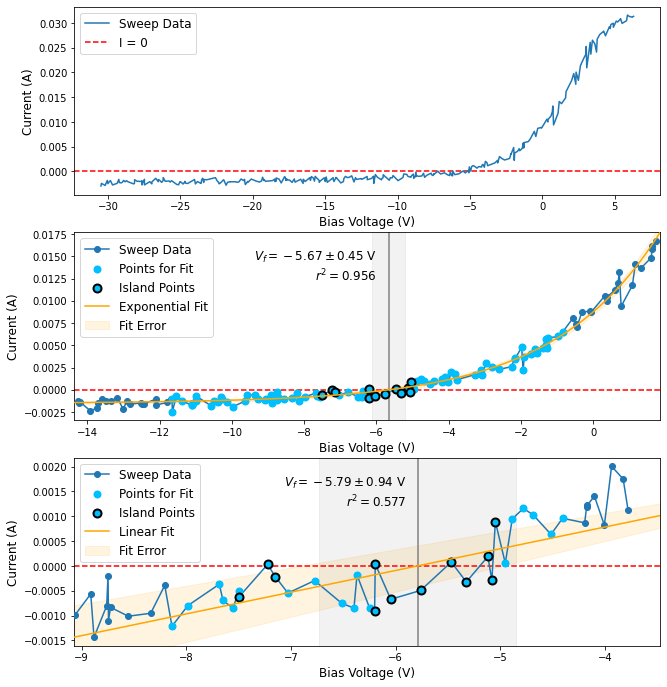

In [10]:
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 2.0 * figheight
fig, axs = plt.subplots(3, 1, figsize=[figwidth, figheight])

# plot original data
axs[0].set_xlabel("Bias Voltage (V)", fontsize=12)
axs[0].set_ylabel("Current (A)", fontsize=12)

axs[0].plot(voltage, current, zorder=10, label="Sweep Data")
axs[0].axhline(0.0, color="r", linestyle="--", label="I = 0")
axs[0].legend(fontsize=12)

# zoom on fit
for ii, label, rtn in zip([1, 2], ["Exponential", "Linear"], [results, results_lin]):
    vf = rtn[0]
    extras = rtn[1]
    
    # calc island points
    isl_pts = np.array([], dtype=np.int64)
    for isl in extras.islands:
        isl_pts = np.concatenate((isl_pts, np.r_[isl]))

    # calc xrange for plot
    xlim = [voltage[extras.fitted_indices].min(), voltage[extras.fitted_indices].max()]
    vpad = 0.25 * (xlim[1] - xlim[0])
    xlim = [xlim[0] - vpad, xlim[1] + vpad]

    # calc data points for fit curve
    mask1 = np.where(voltage >= xlim[0], True, False)
    mask2 = np.where(voltage <= xlim[1], True, False)
    mask = np.logical_and(mask1, mask2)
    vfit = np.linspace(xlim[0], xlim[1], 201, endpoint=True)
    ifit, ifit_err = extras.fitted_func(vfit, reterr=True)

    axs[ii].set_xlabel("Bias Voltage (V)", fontsize=12)
    axs[ii].set_ylabel("Current (A)", fontsize=12)
    axs[ii].set_xlim(xlim)

    axs[ii].plot(
        voltage[mask],
        current[mask],
        marker="o",
        zorder=10,
        label="Sweep Data",
    )
    axs[ii].scatter(
        voltage[extras.fitted_indices],
        current[extras.fitted_indices],
        linewidth=2,
        s=6 ** 2,
        facecolors="deepskyblue",
        edgecolors="deepskyblue",
        zorder=11,
        label="Points for Fit",
    )
    axs[ii].scatter(
        voltage[isl_pts],
        current[isl_pts],
        linewidth=2,
        s=8 ** 2,
        facecolors="deepskyblue",
        edgecolors="black",
        zorder=12,
        label="Island Points",
    )
    axs[ii].autoscale(False)
    axs[ii].plot(vfit, ifit, color="orange", zorder=13, label=label + " Fit")
    axs[ii].fill_between(
        vfit,
        ifit + ifit_err,
        ifit - ifit_err,
        color="orange",
        alpha=0.12,
        zorder=0,
        label="Fit Error",
    )
    axs[ii].axhline(0.0, color="r", linestyle="--")
    axs[ii].fill_between(
        [vf - extras.vf_err, vf + extras.vf_err],
        axs[1].get_ylim()[0],
        axs[1].get_ylim()[1],
        color="grey",
        alpha=0.1,
    )
    axs[ii].axvline(vf, color="grey")
    axs[ii].legend(fontsize=12)

    # add text
    rsq = extras.rsq
    txt = f"$V_f = {vf:.2f} \\pm {extras.vf_err:.2f}$ V\n"
    txt += f"$r^2 = {rsq:.3f}$"
    txt_loc = [vf, axs[ii].get_ylim()[1]]
    txt_loc = axs[ii].transData.transform(txt_loc)
    txt_loc = axs[ii].transAxes.inverted().transform(txt_loc)
    txt_loc[0] -= 0.02
    txt_loc[1] -= 0.26
    axs[ii].text(
        txt_loc[0],
        txt_loc[1],
        txt,
        fontsize="large",
        transform=axs[ii].transAxes,
        ha="right",
    )